In [ ]:
Assignment 3 to use 5 clusters 

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Configure seaborn for consistent plots
sns.set(style='ticks', font_scale=1.75)

# Define function to calculate daily averages over a specified window size
def dailyAvg(data, windowsize):
    data = np.array(data)
    data = data[:windowsize * (len(data) // windowsize)]  # Trim to exact window size
    return np.nanmean(data.reshape(-1, windowsize), axis=1)

# Define function to calculate Vapor Pressure Deficit (VPD)
def calVPD(T, RH):  # T in degrees Celsius, RH as decimal (0-1)
    es = 0.6108 * np.exp(17.27 * T / (T + 237.3))  # Saturated vapor pressure in kPa
    vpd = es * (1 - RH)  # VPD in kPa
    return vpd

# Path to input data
inpath = r'C:\Users\dbryant\Data\\'  # Adjusted file path for Windows
file_name = 'US-MMS_short.csv'
file_path = inpath + file_name

# Load dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError(f"File not found at path: {file_path}")

# Generate monthly time stamps from YEAR, MONTH, and DAY columns
tt_month = [
    datetime(
        int(df['YEAR'].iloc[i * 24 * 30]),
        int(df['MONTH'].iloc[i * 24 * 30]),
        int(df['DAY'].iloc[i * 24 * 30])
    )
    for i in range(len(df) // (24 * 30))
]

# Calculate monthly averages for selected variables
mNEE = -dailyAvg(df['NEE'], 24 * 30)  # Negated for specific context
mT = dailyAvg(df['TA'], 24 * 30)
mRN = dailyAvg(df['SW_NET'], 24 * 30)
mLAI = dailyAvg(df['LAI'], 24 * 30)
mLE = dailyAvg(df['LE'], 24 * 30)
mRH = dailyAvg(df['RH'], 24 * 30)
mSWC = dailyAvg(df['SWC'], 24 * 30)


# Define response variable and predictors
y = mNEE.copy()
X = np.column_stack([mLAI, mT, mRN, mLE, mRH, mSWC])
varlist = np.array(['LAI', 'T', 'Rn', 'LE', 'RH', 'SWC'])

# Generate all possible combinations of 4 explanatory variables
comb = list(combinations(np.arange(X.shape[1]), 4))

# Initialize a list to store model results
results = []

# Loop through each combination, calculate AIC and R², and store the results
for i in range(len(comb)):
    X_subset = X[:, comb[i]]
    model = sm.OLS(y, sm.add_constant(X_subset)).fit()
    AIC = model.aic
    R2 = model.rsquared
    selected_vars = varlist[list(comb[i])]
    results.append((selected_vars, AIC, R2))

# Sort results by AIC (ascending)
sorted_results = sorted(results, key=lambda x: x[1])

# Create a DataFrame to display the top 5 models
top_5_models = pd.DataFrame({
    "Variables": [', '.join(res[0]) for res in sorted_results[:5]],
    "AIC": [res[1] for res in sorted_results[:5]],
    "R2": [res[2] for res in sorted_results[:5]]
})

# Display the top 5 models
print(top_5_models)


Dataset loaded successfully.
         Variables         AIC        R2
0   LAI, T, LE, RH  332.267896  0.928861
1   T, LE, RH, SWC  333.422114  0.928296
2    T, Rn, LE, RH  335.962905  0.927037
3   LAI, T, Rn, LE  343.607576  0.923115
4  LAI, Rn, LE, RH  344.692991  0.922541


In [16]:
# Define response variable and predictors
y = mNEE.copy()
X = np.column_stack([mLAI, mT, mRN, mLE, mRH, mSWC])
varlist = np.array(['LAI', 'T', 'Rn', 'LE', 'RH', 'SWC'])

# Generate all possible combinations of 4 explanatory variables
comb = list(combinations(np.arange(X.shape[1]), 4))

# Initialize a list to store model results
results = []

# Loop through each combination, calculate AIC and R², and store the results
for i in range(len(comb)):
    X_subset = X[:, comb[i]]
    model = sm.OLS(y, sm.add_constant(X_subset)).fit()
    AIC = model.aic
    R2 = model.rsquared
    selected_vars = varlist[list(comb[i])]
    results.append((selected_vars, AIC, R2))

# Sort results by AIC (ascending)
sorted_results = sorted(results, key=lambda x: x[1])

# Create a DataFrame to display the top 5 models
top_5_models = pd.DataFrame({
    "Variables": [', '.join(res[0]) for res in sorted_results[:5]],
    "AIC": [res[1] for res in sorted_results[:5]],
    "R2": [res[2] for res in sorted_results[:5]]
})

# Display the top 5 models
print(top_5_models)

         Variables         AIC        R2
0   LAI, T, LE, RH  332.267896  0.928861
1   T, LE, RH, SWC  333.422114  0.928296
2    T, Rn, LE, RH  335.962905  0.927037
3   LAI, T, Rn, LE  343.607576  0.923115
4  LAI, Rn, LE, RH  344.692991  0.922541


In [18]:
# Generate predictions for the top 5 models
predictions = []
for res in sorted_results[:5]:
    selected_vars = [np.where(varlist == v)[0][0] for v in res[0]]
    X_subset = X[:, selected_vars]
    model = sm.OLS(y, sm.add_constant(X_subset)).fit()
    predictions.append(model.predict(sm.add_constant(X_subset)))

# Convert list of predictions to a numpy array
predictions = np.array(predictions)

# Calculate the ensemble mean (average across the 5 predictions)
ensemble_mean = predictions.mean(axis=0)

# Calculate R² for the ensemble mean
ss_total = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares
ss_residual = np.sum((y - ensemble_mean) ** 2)  # Residual sum of squares
ensemble_r2 = 1 - (ss_residual / ss_total)  # R² formula

print(f"R² of the ensemble mean: {ensemble_r2:.4f}")

R² of the ensemble mean: 0.9281


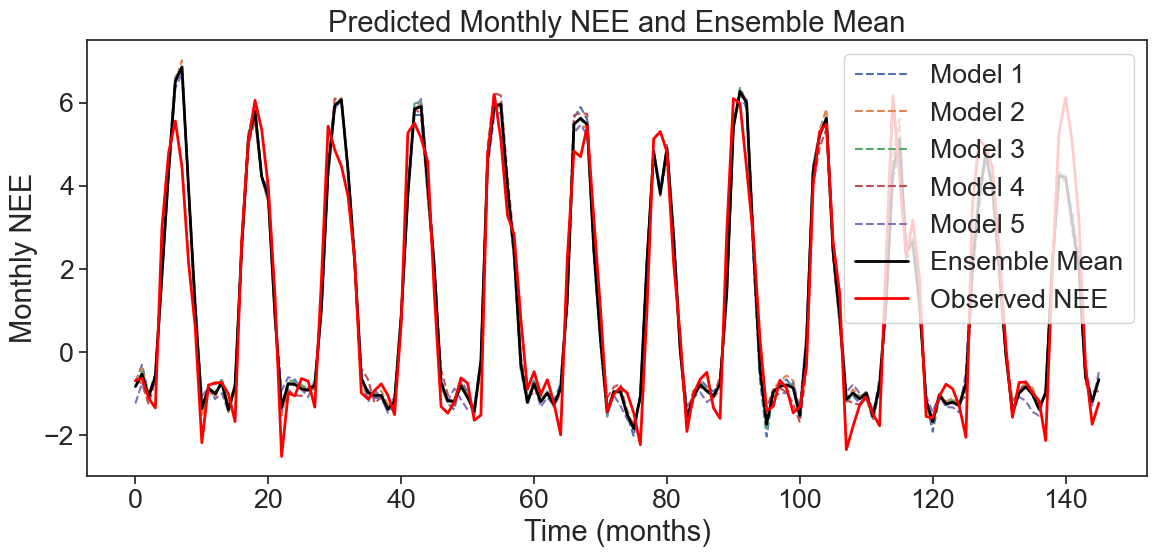

In [20]:
import matplotlib.pyplot as plt

# Generate predictions for the top 5 models
predictions = []
for res in sorted_results[:5]:
    selected_vars = [np.where(varlist == v)[0][0] for v in res[0]]
    X_subset = X[:, selected_vars]
    model = sm.OLS(y, sm.add_constant(X_subset)).fit()
    predictions.append(model.predict(sm.add_constant(X_subset)))

# Convert list of predictions to a numpy array
predictions = np.array(predictions)

# Calculate the ensemble mean (average of the 5 predictions)
ensemble_mean = predictions.mean(axis=0)

# Plot the time series of the predicted monthly NEE for each model and the ensemble mean
plt.figure(figsize=(12, 6))
time = np.arange(len(y))  # Create a time index for plotting
for i, pred in enumerate(predictions):
    plt.plot(time, pred, label=f'Model {i+1}', linestyle='--')
plt.plot(time, ensemble_mean, label='Ensemble Mean', color='black', linewidth=2)
plt.plot(time, y, label='Observed NEE', color='red', linestyle='-', linewidth=2)
plt.xlabel('Time (months)')
plt.ylabel('Monthly NEE')
plt.title('Predicted Monthly NEE and Ensemble Mean')
plt.legend()
plt.tight_layout()
plt.show()


File loaded successfully:
  SITE_ID  PFT KoeppenGeiger  latitude  longitude   dataset  TZ  nyears  \
0  AR-Vir  ENF           Cfa  -28.2395   -56.1886  Berkeley  -4       4   
1  AT-Neu  GRA           Dfc   47.1167    11.3175  Berkeley   1      11   
2  AU-Ade  SAV            Aw  -13.0769   131.1178  Berkeley   8       3   
3  AU-ASM  ENF           BSh  -22.2830   133.2490  Berkeley   8       5   
4  AU-Cpr  SAV           BSk  -34.0021   140.5891  Berkeley   8       5   

        WUE      uWUE  ...      WUEt     Nmass  LAImax        SWin       Tair  \
0  3.756653  4.336426  ...       NaN       NaN     NaN  226.631078  23.455699   
1  4.150454  4.563017  ...  0.250152  2.906181   6.500  136.208461   6.763112   
2  1.691328  2.419987  ...       NaN       NaN   2.040  235.046924  27.426997   
3  1.600938  2.552875  ...  0.081484  1.776368   0.470  265.270436  22.792080   
4  2.123031  2.719756  ...  0.126235  1.242741   0.782  219.199492  17.868690   

         VPD           P      CSWI  

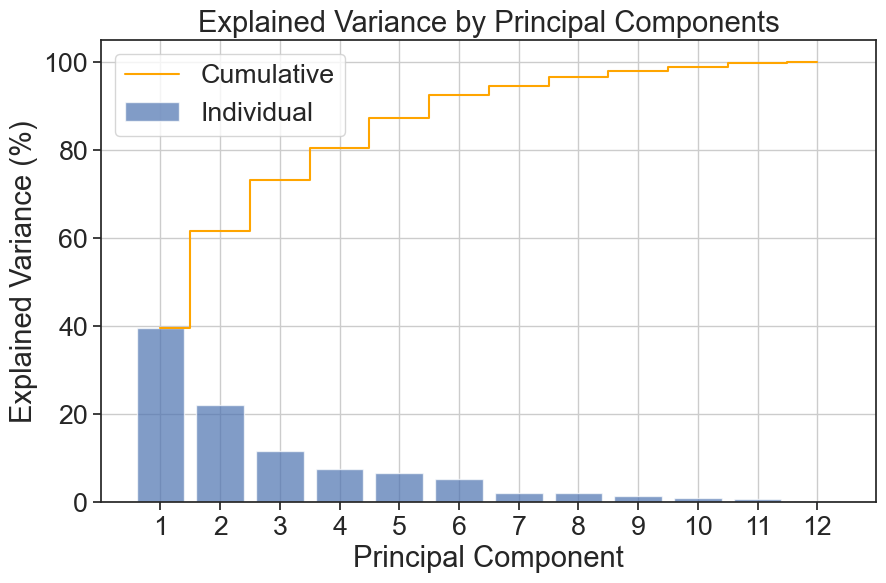

In [24]:
# load the packages and read the csv into a dataframe df

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks',font_scale=1.75)
from sklearn.linear_model import LinearRegression

# Correct file path for Windows
fname = r'C:\Users\dbryant\Data\InputDataMigliavacca2021.csv'  # Use raw string for file path
if os.path.exists(fname):
    df = pd.read_csv(fname)
    print("File loaded successfully:")
    print(df.head())
else:
    print(f"File not found: {fname}")

# List of traits (variables) to analyze
traits = ['WUEt', 'uWUE', 'Rbmax', 'Rb', 'NEPmax', 'GSmax', 'GPPsat', 
          'G1', 'ETmax', 'EFampl', 'EF', 'aCUE']

# Extract the relevant data and remove rows with missing values
X0 = df[traits].dropna().values

# Define a function for PCA analysis
def f_pca(X0):
    # Normalize the dataset
    X = (X0 - np.mean(X0, axis=0)) / np.std(X0, axis=0)
    # Calculate the covariance matrix
    S = np.dot(np.transpose(X), X) / X.shape[0]
    # Perform eigen decomposition
    w, v = np.linalg.eig(S)
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(w)[::-1]
    w_sorted = w[idx]
    v_sorted = v[:, idx]
    return w_sorted, v_sorted

# Perform PCA
w_sorted, v_sorted = f_pca(X0)

# Calculate the variance explained by each principal component
variance_explained = w_sorted / np.sum(w_sorted) * 100
cumulative_variance = np.cumsum(variance_explained)

# Display the results
print("Variance explained by the first three PCs:")
for i in range(3):
    print(f"PC{i+1}: {variance_explained[i]:.2f}%")

print("\nCumulative variance explained by the first three PCs:")
print(f"{cumulative_variance[2]:.2f}%")

# Visualize the variance explained
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(variance_explained)+1), variance_explained, alpha=0.7, label='Individual')
plt.step(range(1, len(cumulative_variance)+1), cumulative_variance, where='mid', label='Cumulative', color='orange')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, len(variance_explained)+1))
plt.legend()
plt.grid(True)
plt.show()


Bootstrapped Variance Explained by PCs:
PC1: 40.46% ± 2.41%
PC2: 22.16% ± 1.74%
PC3: 11.55% ± 0.87%


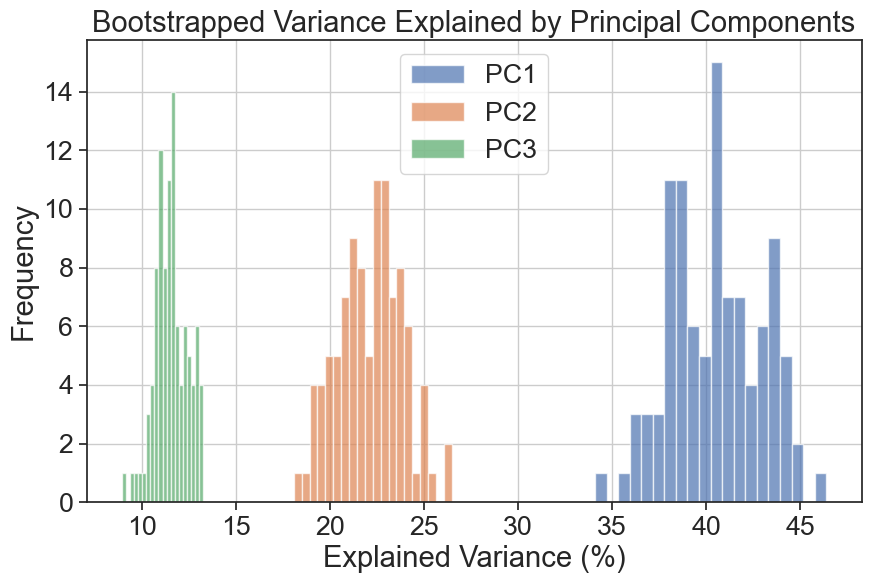

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# List of traits (variables) to analyze
traits = ['WUEt', 'uWUE', 'Rbmax', 'Rb', 'NEPmax', 'GSmax', 'GPPsat', 
          'G1', 'ETmax', 'EFampl', 'EF', 'aCUE']

# Extract the relevant data and remove rows with missing values
X0 = df[traits].dropna().values

# Define a function for PCA analysis
def f_pca(X0):
    # Normalize the dataset
    X = (X0 - np.mean(X0, axis=0)) / np.std(X0, axis=0)
    # Calculate the covariance matrix
    S = np.dot(np.transpose(X), X) / X.shape[0]
    # Perform eigen decomposition
    w, v = np.linalg.eig(S)
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(w)[::-1]
    w_sorted = w[idx]
    v_sorted = v[:, idx]
    return w_sorted, v_sorted

# Define a function to perform bootstrapping and calculate PCA variance explained
def bootstrap_pca(X0, n_trials=100):
    n_samples = X0.shape[0]
    variance_explained_trials = []

    for _ in range(n_trials):
        # Resample the rows of X0 with replacement
        resampled_indices = np.random.choice(n_samples, n_samples, replace=True)
        X_resampled = X0[resampled_indices, :]
        
        # Perform PCA on the resampled dataset
        w_sorted, _ = f_pca(X_resampled)
        
        # Calculate the percentage of variance explained
        variance_explained = w_sorted / np.sum(w_sorted) * 100
        variance_explained_trials.append(variance_explained[:3])  # Keep only the first three PCs
    
    return np.array(variance_explained_trials)

# Perform bootstrapping with 100 trials
n_trials = 100
variance_explained_trials = bootstrap_pca(X0, n_trials=n_trials)

# Calculate uncertainty range for each PC (mean ± std deviation)
mean_variance_explained = np.mean(variance_explained_trials, axis=0)
std_variance_explained = np.std(variance_explained_trials, axis=0)

# Report results
print("Bootstrapped Variance Explained by PCs:")
for i in range(3):
    print(f"PC{i+1}: {mean_variance_explained[i]:.2f}% ± {std_variance_explained[i]:.2f}%")

# Visualize bootstrapping results
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.hist(variance_explained_trials[:, i], bins=20, alpha=0.7, label=f'PC{i+1}')
plt.xlabel('Explained Variance (%)')
plt.ylabel('Frequency')
plt.title('Bootstrapped Variance Explained by Principal Components')
plt.legend()
plt.grid(True)
plt.show()


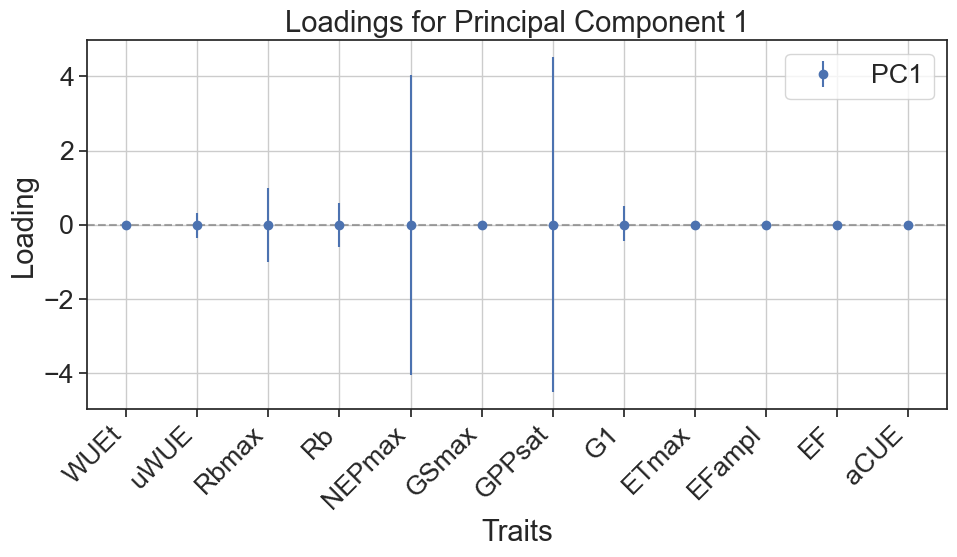

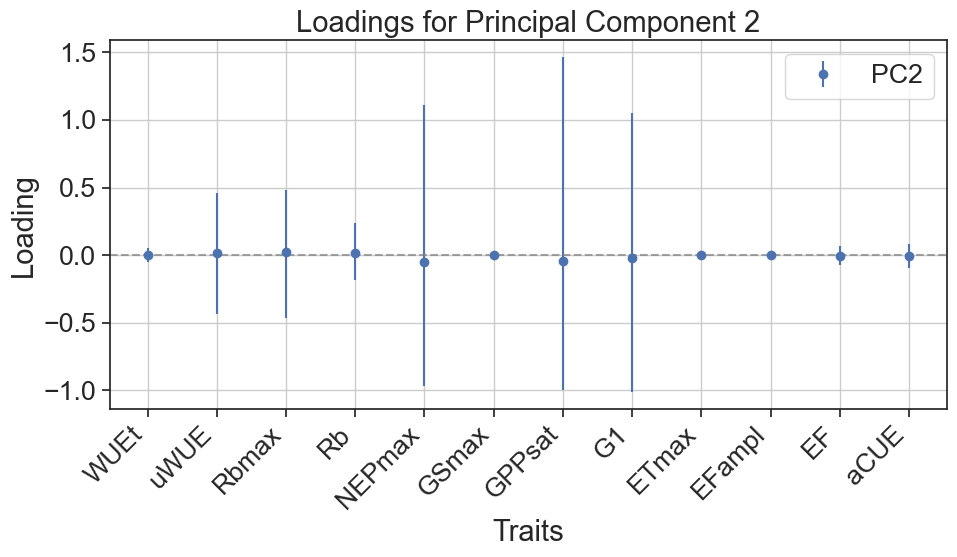

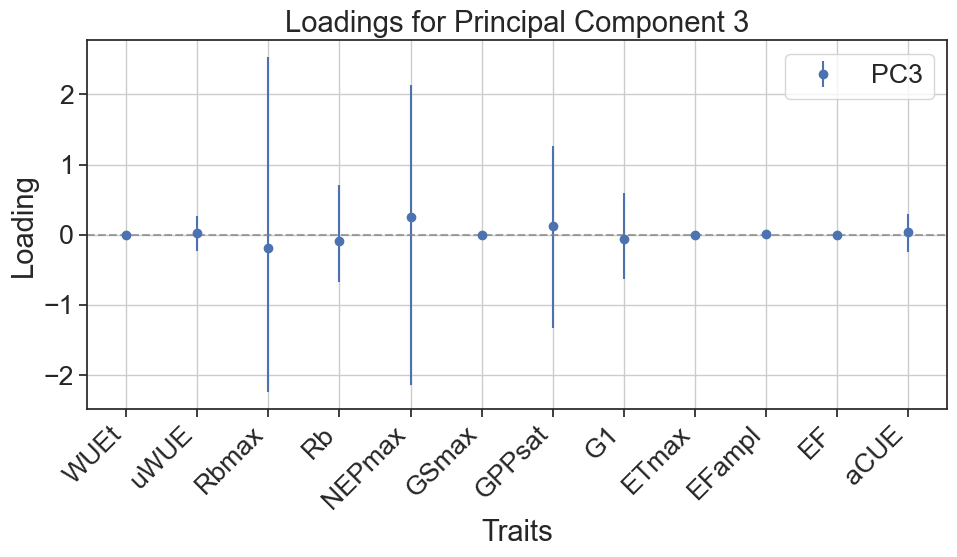

In [32]:
# Define a function to compute loadings from eigenvectors and standard deviations
def compute_loadings(v_sorted, std_devs):
    return v_sorted * std_devs[:, np.newaxis]

# Perform bootstrapping to collect loadings for each PC
def bootstrap_loadings(X0, n_trials=100):
    n_samples = X0.shape[0]
    loadings_trials = []

    for _ in range(n_trials):
        # Resample the rows of X0 with replacement
        resampled_indices = np.random.choice(n_samples, n_samples, replace=True)
        X_resampled = X0[resampled_indices, :]
        
        # Perform PCA on the resampled dataset
        w_sorted, v_sorted = f_pca(X_resampled)
        
        # Calculate the standard deviations of the original variables
        std_devs = np.std(X_resampled, axis=0)
        
        # Calculate loadings
        loadings = compute_loadings(v_sorted, std_devs)
        loadings_trials.append(loadings[:, :3])  # Keep only the first three PCs

    return np.array(loadings_trials)

# Perform bootstrapping for loadings
loadings_trials = bootstrap_loadings(X0, n_trials=n_trials)

# Calculate average and range (min/max) of loadings
mean_loadings = np.mean(loadings_trials, axis=0)
min_loadings = np.min(loadings_trials, axis=0)
max_loadings = np.max(loadings_trials, axis=0)

# Plot the loadings for each PC
pcs = [1, 2, 3]
for i, pc in enumerate(pcs):
    plt.figure(figsize=(10, 6))
    plt.errorbar(range(len(traits)), mean_loadings[:, i], 
                 yerr=[mean_loadings[:, i] - min_loadings[:, i], 
                       max_loadings[:, i] - mean_loadings[:, i]], 
                 fmt='o', label=f'PC{pc}')
    plt.xticks(range(len(traits)), traits, rotation=45, ha='right')
    plt.axhline(0, linestyle='--', color='gray', alpha=0.7)
    plt.title(f'Loadings for Principal Component {pc}')
    plt.ylabel('Loading')
    plt.xlabel('Traits')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


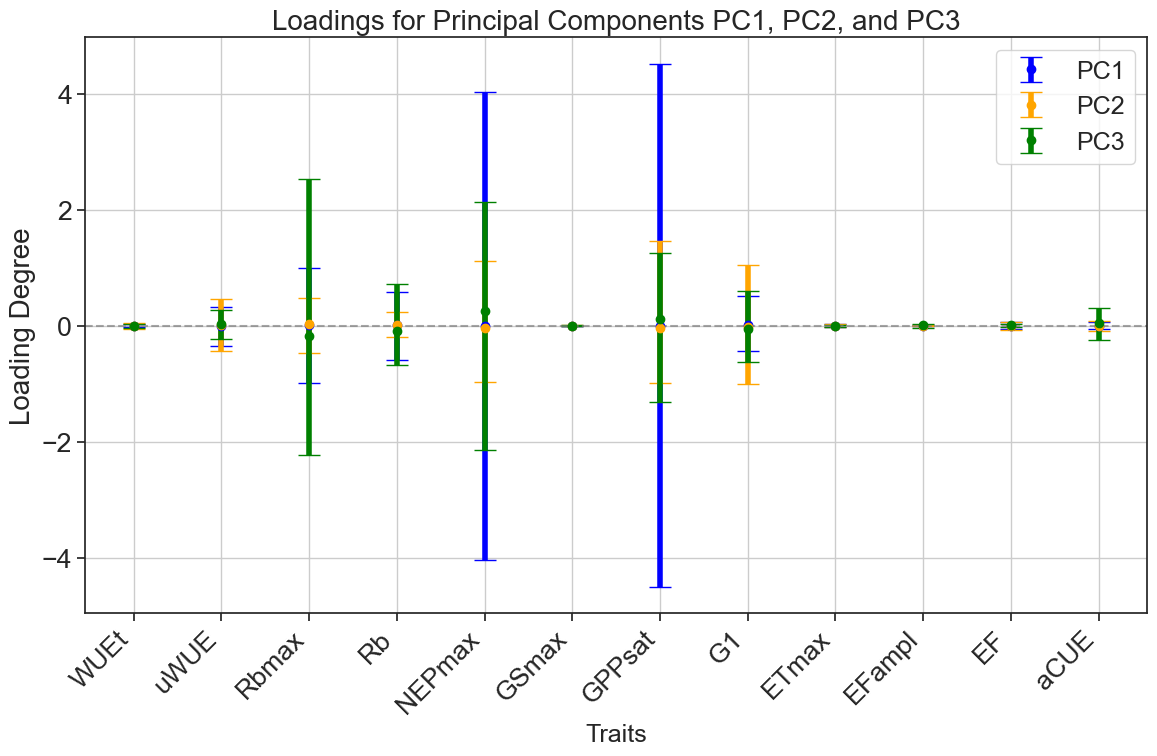

In [85]:
# Combined plot of loadings for PC1, PC2, and PC3
plt.figure(figsize=(12, 8))

# Colors for each PC
colors = ['blue', 'orange', 'green']

for i, pc in enumerate(pcs):
    plt.errorbar(range(len(traits)), mean_loadings[:, i], 
                 yerr=[mean_loadings[:, i] - min_loadings[:, i], 
                       max_loadings[:, i] - mean_loadings[:, i]], 
                 fmt='o', label=f'PC{pc}', color=colors[i], linewidth=4, capsize=8)

# Plot settings
plt.xticks(range(len(traits)), traits, rotation=45, ha='right')
plt.axhline(0, linestyle='--', color='gray', alpha=0.7, linewidth=1.5)
plt.title('Loadings for Principal Components PC1, PC2, and PC3', fontsize=20)
plt.ylabel('Loading Degree', fontsize=20)
plt.xlabel('Traits', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()


In [63]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split  # Ensure this is imported
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import os
# Data preparation: select relevant columns and drop rows with missing values
selected_columns = ['AGB', 'SWin', 'Tair', 'VPD', 'P', 'Hc']
df_cleaned = df[selected_columns].dropna()

# Split data into predictors (X) and target (y)
X = df_cleaned[['SWin', 'Tair', 'VPD', 'P', 'Hc']]
y = df_cleaned['AGB']

# Split into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model accuracy
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print(f"Training R2: {r2_train:.4f}")
print(f"Testing R2: {r2_test:.4f}")

Training R2: 0.9424
Testing R2: 0.5758


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

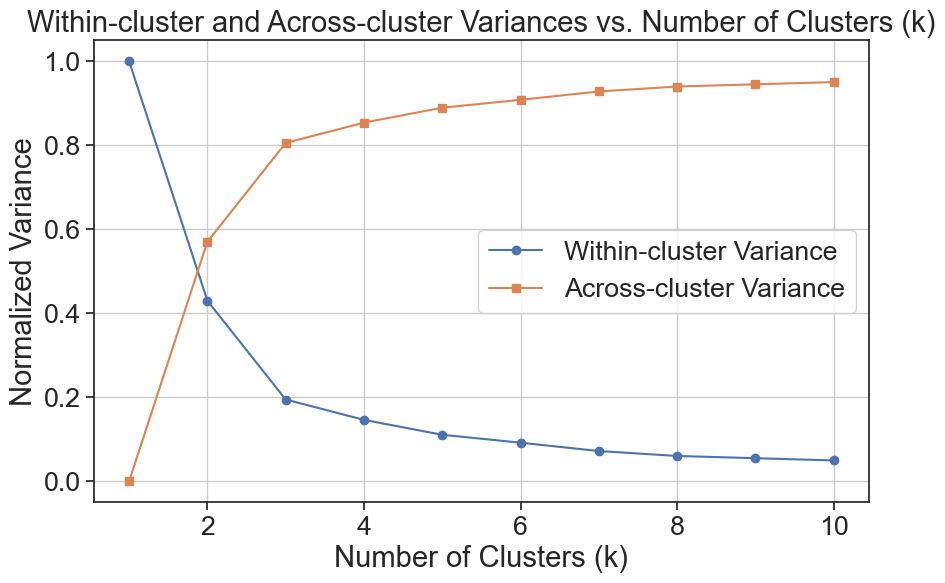

In [65]:
from sklearn.cluster import KMeans
# Extract relevant columns and remove missing values
data = df[['Tair', 'P']].dropna().values

# Initialize lists to store variances
within_cluster_variance = []
across_cluster_variance = []

# Total variance (global mean as reference point)
global_mean = data.mean(axis=0)
total_variance = ((data - global_mean) ** 2).sum()

# Iterate over a range of k values
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    
    # Within-cluster variance (inertia)
    within_cluster_variance.append(kmeans.inertia_)
    
    # Across-cluster variance: Total variance - Within-cluster variance
    across_cluster_variance.append(total_variance - kmeans.inertia_)

# Normalize the variances for plotting (optional)
within_cluster_variance = [v / total_variance for v in within_cluster_variance]
across_cluster_variance = [v / total_variance for v in across_cluster_variance]

# Plot the variances
plt.figure(figsize=(10, 6))
plt.plot(k_values, within_cluster_variance, label="Within-cluster Variance", marker='o')
plt.plot(k_values, across_cluster_variance, label="Across-cluster Variance", marker='s')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Normalized Variance")
plt.title("Within-cluster and Across-cluster Variances vs. Number of Clusters (k)")
plt.legend()
plt.grid()
plt.show()

In [67]:
# Extract relevant columns and remove missing values
data = df[['Tair', 'P']].dropna().values
n_samples = data.shape[0]  # Total number of data points

# Initialize lists to store average variances
avg_within_cluster_variance = []
avg_across_cluster_variance = []

# Total variance (global mean as reference point)
global_mean = data.mean(axis=0)
total_variance = ((data - global_mean) ** 2).sum() / n_samples

# Iterate over a range of k values
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    
    # Within-cluster variance (inertia)
    avg_within_variance = kmeans.inertia_ / n_samples
    avg_within_cluster_variance.append(avg_within_variance)
    
    # Across-cluster variance: Total variance - Within-cluster variance
    avg_across_variance = total_variance - avg_within_variance
    avg_across_cluster_variance.append(avg_across_variance)

# Print average variances for each k
for i, k in enumerate(k_values):
    print(f"k = {k}: Avg Within-cluster Variance = {avg_within_cluster_variance[i]:.4f}, "
          f"Avg Across-cluster Variance = {avg_across_cluster_variance[i]:.4f}")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

k = 1: Avg Within-cluster Variance = 1737.8837, Avg Across-cluster Variance = 0.0000
k = 2: Avg Within-cluster Variance = 747.0142, Avg Across-cluster Variance = 990.8694
k = 3: Avg Within-cluster Variance = 338.1742, Avg Across-cluster Variance = 1399.7094
k = 4: Avg Within-cluster Variance = 254.0265, Avg Across-cluster Variance = 1483.8572
k = 5: Avg Within-cluster Variance = 192.2796, Avg Across-cluster Variance = 1545.6041
k = 6: Avg Within-cluster Variance = 159.5301, Avg Across-cluster Variance = 1578.3536
k = 7: Avg Within-cluster Variance = 125.0643, Avg Across-cluster Variance = 1612.8194
k = 8: Avg Within-cluster Variance = 104.5898, Avg Across-cluster Variance = 1633.2938
k = 9: Avg Within-cluster Variance = 95.3606, Avg Across-cluster Variance = 1642.5231
k = 10: Avg Within-cluster Variance = 86.1966, Avg Across-cluster Variance = 1651.6870


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
